In [24]:
import numpy as np
import pandas as pd
import time
import torch
import torch.nn as nn
import torchvision
from PIL import Image
from pathlib import Path
from torchvision import datasets, models, transforms
from torchvision.transforms.functional import to_pil_image, to_tensor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from torch.utils.data import Dataset, DataLoader
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report
import os
from sklearn.model_selection import train_test_split
import seaborn as sns
from collections import Counter
import shutil
import torchvision.models as models
from collections import Counter
import timm
from itertools import groupby

In [12]:
torch.manual_seed(42)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [13]:
# разные режимы загрузки датасета
data_modes = ['train', 'val', 'test']
class SmokingDataset(Dataset):
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode
        self.len_ = len(self.files)
        self.label_encoder = LabelEncoder()
        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)
    def __len__(self):
        return self.len_
    def load_sample(self, file):
        image = Image.open(file).convert("RGB")
        image.load()
        return image
    def __getitem__(self, index):
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
    def _prepare_sample(self, image):
        image = image.resize((128, 128))
        return np.array(image)

In [48]:
train_dir = Path('D:\\Книги\\Программирование\\ML_contests_хакатоны\\Ozon_2024\\train_lite')
train_val_files = list(train_dir.rglob('*.jpg'))
train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, stratify=train_val_labels)
train_dataset = SmokingDataset(train_files, mode='train')
val_dataset = SmokingDataset(val_files, mode='val')

In [49]:
len(val_dataset)

308

In [15]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    plt_ax.imshow(inp)
    plt_ax.set_title(title)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


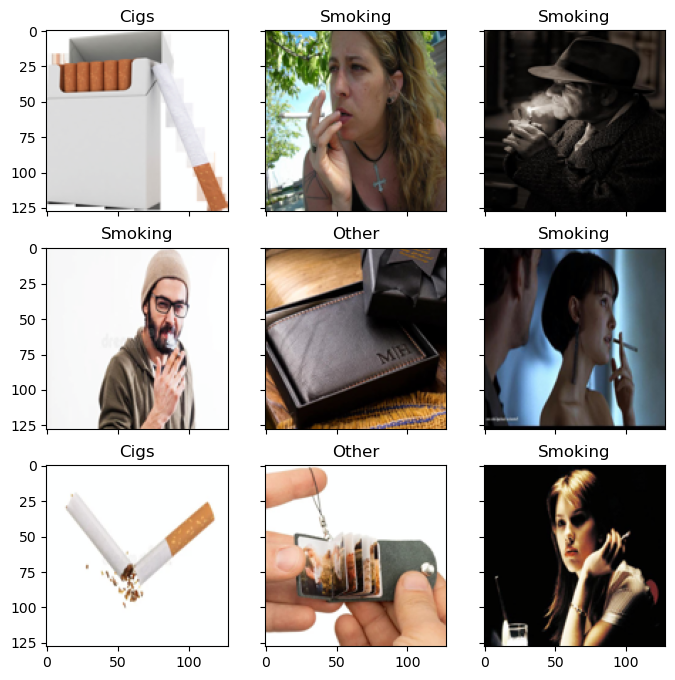

In [16]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0, 916))
    im_val, label = train_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                train_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label, plt_ax=fig_x)

In [50]:
class_names = train_dataset.label_encoder.classes_
print(len(class_names))
print(class_names)

5
['cigs' 'other' 'pipes' 'roll_cigs' 'smoking']


In [51]:
len(train_files)

922

In [19]:
from collections import Counter
train_labels = [path.parent.name for path in train_files]
train_counter = Counter(train_labels)
print("Количество объектов в каждом классе тренировочной выборки:")
for class_name, count in train_counter.items():
    print(f"Класс {class_name}, количество {count}, доля {count * 100 / len(train_files):.2f}%")

Количество объектов в каждом классе тренировочной выборки:
Класс cigs, количество 76, доля 7.94%
Класс other, количество 94, доля 9.82%
Класс smoking, количество 688, доля 71.89%
Класс pipes, количество 49, доля 5.12%
Класс roll_cigs, количество 50, доля 5.22%


In [25]:
# Определим трансформации для аугментации
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=(0, 90)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomResizedCrop(size=(128, 128), scale=(0.8, 1.0))
])

# Определим папку с изображениями и читаем пути к ним
train_files = list(Path('D:\\Книги\\Программирование\\ML_contests_хакатоны\\Ozon_2024\\train_lite').rglob("*.jpg"))

# Получим метки классов и количество изображений в каждом классе
train_labels = [path.parent.name for path in train_files]
counter = Counter(train_labels)
max_count = 2978


# Создадим папку для увеличенных данных
augmented_data_dir = Path('D:\\Книги\\Программирование\\ML_contests_хакатоны\\Ozon_2024\\train_lite_augmented')
augmented_data_dir.mkdir(exist_ok=True)

# Создадим подкатегории для каждого класса
for label in counter.keys():
    (augmented_data_dir / label).mkdir(exist_ok=True)

total_augmented = 0

# Копируем оригинальные изображения и создаем дополнительные для классов с меньшим количеством изображений
for label, files in groupby(sorted(train_files, key=lambda x: x.parent.name), key=lambda x: x.parent.name):
    files = list(files)
    count = len(files)
    dest_dir = augmented_data_dir / label
    
    # Копируем оригинальные изображения
    for file in files:
        shutil.copy(file, dest_dir / file.name)

    if count < max_count:
        # Создаем дополнительные изображения для меньшинственных классов
        additional_files_needed = max_count - count
        total_augmented += additional_files_needed
        
        # Равномерное распределение аугментаций по всем изображениям
        for i in range(additional_files_needed):
            file = files[i % count]  # Берем изображение по циклическому индексу
            new_file = dest_dir / f"{file.stem}_aug_{i}.jpg"
            original_image = Image.open(file)
            augmented_image = transform(original_image)
            augmented_image = augmented_image.convert("RGB")
            augmented_image.save(new_file, "JPEG", quality=85)  # Сохраняем с качеством 85
            
    counter[label] = max_count  # Обновим количество изображений для класса до максимального значения

print(f"Total augmented images created: {total_augmented}")

Total augmented images created: 13614


In [52]:
# Обновим список файлов и метки
train_files = list(train_lite_augmented_dir.glob('**/*.jpg'))
train_labels = [path.parent.name for path in train_files]

In [53]:
train_counter = Counter(train_labels)

print("Количество объектов в каждом классе тренировочной выборки:")
for class_name, count in train_counter.items():
    print(f"Класс {class_name}, количество {count}, доля {count * 100 / len(train_files):.2f}%")

Количество объектов в каждом классе тренировочной выборки:
Класс cigs, количество 2978, доля 20.00%
Класс other, количество 2978, доля 20.00%
Класс pipes, количество 2978, доля 20.00%
Класс roll_cigs, количество 2978, доля 20.00%
Класс smoking, количество 2978, доля 20.00%


In [54]:
train_dataset = SmokingDataset(train_files, mode='train')
val_dataset = SmokingDataset(val_files, mode='val')

In [55]:
len(val_dataset)

308

In [56]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                              batch_size=32,
                              shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                             batch_size=32,
                             shuffle=False)
train_loader, val_loader

(<torch.utils.data.dataloader.DataLoader at 0x1702c281190>,
 <torch.utils.data.dataloader.DataLoader at 0x17023dffd50>)

In [57]:
def train(model, train_loader, val_loader, loss_fn, optimizer, epochs):
    model.to(device)
    model.train()
    start_time = time.time()
    for epoch in range(epochs):
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f'Эпоха {epoch+1}')
        val_loss, val_report = evaluate(model, val_loader, loss_fn)
    end_time = time.time()
    train_time = end_time - start_time
    print(f"Время обучения: {train_time} секунд")
    return model, train_time

def evaluate(model, data_loader, loss_fn):
    total_loss = 0
    all_preds = []
    all_labels = []
    model.to(device)
    model.eval()

    with torch.inference_mode():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            loss = loss_fn(pred, y)
            total_loss += loss.item()
            pred = torch.argmax(pred, dim=1)
            all_preds.append(pred.cpu())
            all_labels.append(y.cpu())

    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)

    mean_loss = total_loss / len(data_loader)
    report = classification_report(all_labels, all_preds, output_dict=True)

    print(f"Функция потерь (кросс-энтропия) на данных: {mean_loss}")
    print(f"Precision: {report['weighted avg']['precision']}")
    print(f"Recall: {report['weighted avg']['recall']}")
    print(f"F1-мера: {report['weighted avg']['f1-score']}")

    return mean_loss, report

In [58]:
def showmatrix(conf):
    df_conf = pd.DataFrame(conf,
                      index=class_names,
                      columns=class_names)
    plt.figure(figsize=(20, 16))
    sns.heatmap(df_conf, annot=True, cmap='Blues', fmt='g')
    plt.show()

In [59]:
# Загрузка модели ConvNeXt V2 Tiny через timm
model_ConvNeXtV2 = timm.create_model('convnextv2_tiny', pretrained=True)

# Адаптация последнего слоя под 5 классов
model_ConvNeXtV2.head.fc = nn.Linear(model_ConvNeXtV2.head.fc.in_features, 5)

# Сохранение модели
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# Например, сохранение модели
torch.save(model_ConvNeXtV2.state_dict(), MODEL_PATH / "convnext_v2_tiny_5_classes.pth")

In [60]:
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

In [61]:
loss_fn = torch.nn.CrossEntropyLoss()

In [62]:
# Пример проверки размерностей
for images, labels in train_loader:
    print(images.size())  # Ожидается (batch_size, 3, height, width)
    print(labels.size())  # Ожидается (batch_size, )
    break

torch.Size([32, 3, 128, 128])
torch.Size([32])


In [66]:
def train(model, train_loader, val_loader, loss_fn, optimizer, epochs, scheduler=None):
    model.to(device)
    model.train()
    start_time = time.time()
    for epoch in range(epochs):
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            # Прямой проход
            y_pred = model(X_batch)
            # Вычисление потерь
            loss = loss_fn(y_pred, y_batch)
            # Обнуление градиентов
            optimizer.zero_grad()
            # Обратное распространение
            loss.backward()
            # Обновление параметров модели
            optimizer.step()
        # Валидация на конце каждой эпохи
        print(f'Эпоха {epoch+1}')
        val_loss, val_report = evaluate(model, val_loader, loss_fn)
        # Обновление скорости обучения
        if scheduler:
            scheduler.step()
    end_time = time.time()
    train_time = end_time - start_time
    print(f"Время обучения: {train_time:.2f} секунд")
    return model, train_time

In [67]:
optimizer = torch.optim.Adam(model_ConvNeXtV2.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
model_ConvNeXtV2, train_time = train(model_ConvNeXtV2, train_loader, val_loader, loss_fn, optimizer, 5)

Эпоха 1
Функция потерь (кросс-энтропия) на данных: 1.1466653168201446
Precision: 0.7056012605252848
Recall: 0.42207792207792205
F1-мера: 0.4827971537057923
Эпоха 2
Функция потерь (кросс-энтропия) на данных: 1.2562448978424072
Precision: 0.7751981024708297
Recall: 0.4512987012987013
F1-мера: 0.48581616924647536
Эпоха 3
Функция потерь (кросс-энтропия) на данных: 1.3478443294763565
Precision: 0.8230056908066806
Recall: 0.5357142857142857
F1-мера: 0.571228151699341
Эпоха 4
Функция потерь (кросс-энтропия) на данных: 0.8320251479744911
Precision: 0.8564046579050903
Recall: 0.6688311688311688
F1-мера: 0.7092554702808787
Эпоха 5
Функция потерь (кросс-энтропия) на данных: 0.5387060701847076
Precision: 0.869693171928432
Recall: 0.801948051948052
F1-мера: 0.8190925250950805
Время обучения: 36103.64 секунд


In [71]:
COVNEXTV2 = Path("D:/Книги/Программирование/ML_contests_хакатоны/Ozon_2024/model_ConvNeXtV2_lite_epochs5.pth")
torch.save(obj=model_ConvNeXtV2.state_dict(), f=str(COVNEXTV2))

In [69]:
"""
# Colab-версия
COVNEXTV2 = "D:\\Книги\\Программирование\\ML_contests_хакатоны\\Ozon_2024\\model_ConvNeXtV2_5.pth"
torch.save(obj=model_ConvNeXtV2.state_dict(),
           f=COVNEXTV2)
files.download(COVNEXTV2)
"""

AttributeError: 'list' object has no attribute 'download'